Importing Python Libraries

In [33]:
#Vidit's Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import streamlit as st
import plotly.express as px

In [34]:
#reading the file
data_delhi = pd.read_csv(r"D:\CODING\Data Science\Restaurants\New_Delhi_data.csv",encoding='unicode_escape')

EDA : Exploratory Data Analysis

In [35]:
data_delhi['Restaurant Name'].value_counts().head(20)

Restaurant Name
Cafe Coffee Day        54
Domino's Pizza         50
Subway                 33
Green Chick Chop       32
McDonald's             32
Keventers              21
Giani                  21
Giani's                17
Wah Ji Wah             12
Pizza Hut Delivery     12
Baskin Robbins         12
Sagar Ratna            11
Moti Mahal Delux       11
Pizza Hut              11
Republic of Chicken    11
Twenty Four Seven      10
Bikaner Sweets         10
Frontier               10
Haldiram's             10
Bikanervala            10
Name: count, dtype: int64

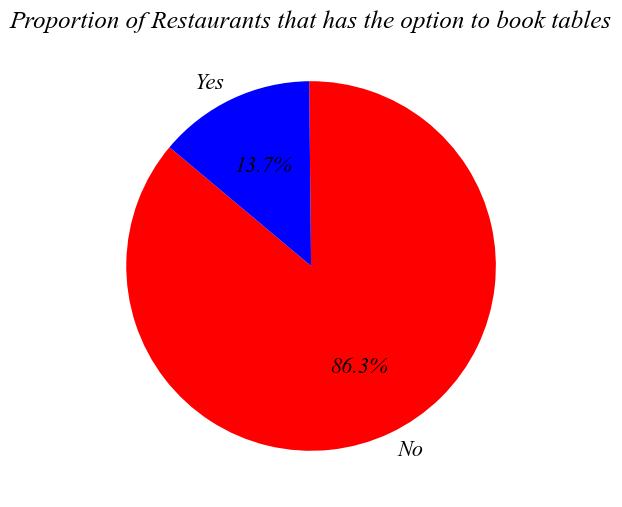

In [36]:
#make a pie chart here for Table booking
# Create a pie chart
plt.rcParams['font.style'] = 'italic'
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(6, 6))
plt.pie(x = data_delhi['Has Table booking'].value_counts().to_list(),
       labels=['No','Yes'],
       autopct='%1.1f%%', startangle=140, colors=['red', 'blue'],textprops={'fontsize': 16}) 
plt.title('Proportion of Restaurants that has the option to book tables',fontdict=dict(fontsize=18))
plt.show()

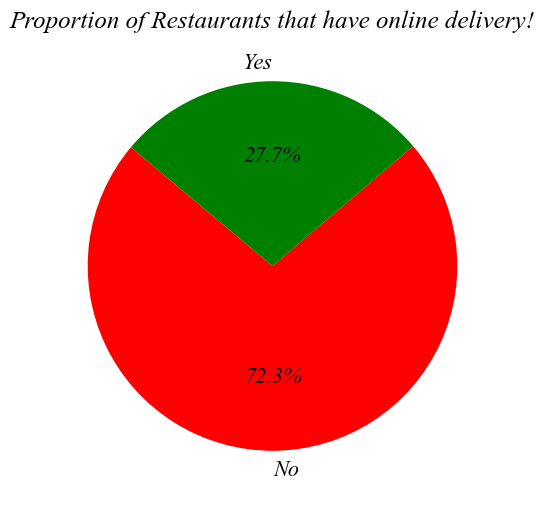

In [37]:
# pie  chart for Online Delivery
# Create a pie chart
plt.rcParams['font.style'] = 'italic'
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(6, 6))
plt.pie(x = data_delhi['Has Online delivery'].value_counts().to_list(),
       labels=['No','Yes'],
       autopct='%1.1f%%', startangle=140, colors=['red', 'green'],textprops={'fontsize': 16}) 
plt.title('Proportion of Restaurants that have online delivery!',fontdict=dict(fontsize=18))
plt.show()

## Predictive Model Development

In [ ]:
import codecs  # Add codecs import for encoding handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import streamlit.components.v1 as components

# Streamlit configuration
st.set_page_config(layout='wide', initial_sidebar_state='collapsed')

# Reading the file
data_delhi = pd.read_csv("D:/CODING/Data Science/Restaurants/New_Delhi_data.csv", encoding='unicode_escape')

# Dropping the columns that don't help in analysis
model_data = data_delhi.drop(['Restaurant ID', 'Restaurant Name', 'City', 'Address', 'Locality', 'Cuisines'], axis=1)

# Filtering out the 'Not rated' entries
filter_data = model_data[model_data['Rating text'] != 'Not rated']

# Function to separate excellent values
def excel_sep(text):
    return 1 if text == 'Excellent' else 0

# Creating a dependent variable
filter_data['Dep_Excellent_Rating'] = filter_data['Rating text'].apply(excel_sep)

# Dropping other required variables
filter_data.drop(['Aggregate rating', 'Rating color', 'Rating text'], axis=1, inplace=True)

# Encoding the categorical values
filter_data['Has Table booking'] = pd.get_dummies(filter_data['Has Table booking'], drop_first=True)
filter_data['Has Online delivery'] = pd.get_dummies(filter_data['Has Online delivery'], drop_first=True)

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filter_data.drop('Dep_Excellent_Rating', axis=1))
scaled_features_df = pd.DataFrame(scaled_features, columns=filter_data.drop('Dep_Excellent_Rating', axis=1).columns)

# Streamlit display
components.html(codecs.open("components.html", 'r', 'utf-8').read(), height=100)  # Specify encoding as utf-8

st.sidebar.title("About Us")
st.sidebar.write("This model is designed for restaurants to view the dependency of their ratings using logistic regression. It helps understand which factors contribute most to excellent ratings.")
st.sidebar.write("Made with ❤️ by Vidit !")
st.write('\n')
st.title("Logistic Regression Analysis on New Delhi Restaurant Data")
st.write('\n')


# Adding filter options
feature_options = scaled_features_df.columns.tolist()
selected_features = st.multiselect('Select features to include in the model', feature_options, default=feature_options)

if selected_features:
    # Splitting the data into dependent and independent variables based on selection
    y = filter_data['Dep_Excellent_Rating']
    X = scaled_features_df[selected_features]

    # Using SMOTE for oversampling
    smt = SMOTE(random_state=42)
    X_smt, y_smt = smt.fit_resample(X, y)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=.25, random_state=42)

    # Model 
    model_lr = LogisticRegression(random_state=42)
    model_lr.fit(X_train, y_train)

    # Model has learned
    y_pred = model_lr.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Not Excellent', 'Excellent'], columns=['Predicted Not Excellent', 'Predicted Excellent'])

    # Create a heatmap for confusion matrix
    fig_cm = go.Figure(data=go.Heatmap(
        z=cm_df.values,
        x=cm_df.columns,
        y=cm_df.index,
        colorscale='Reds',
        text=cm_df.values,
        texttemplate="%{text}",
        hoverinfo='text'
    ))

    fig_cm.update_layout(
        title='Confusion Matrix',
        xaxis_title='Predicted',
        yaxis_title='Actual',
        xaxis={'side': 'top'}
    )

    st.plotly_chart(fig_cm, use_container_width=True)

    # Feature importance
    coefficients = model_lr.coef_[0]
    feature_names = [f'{i}' for i in X.columns.to_list()]
    df_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient Value': coefficients.round(2)})
    df_coefficients['Odds Ratio'] = np.exp(df_coefficients['Coefficient Value']).round(2)
    df_coefficients_sorted = df_coefficients.sort_values(by='Coefficient Value', ascending=False)
    feat_importance = px.bar(df_coefficients_sorted, 
                             y='Coefficient Value', 
                             x='Feature', 
                             orientation='v', 
                             title='Feature Importance in Logistic Regression',
                             labels={'Coefficient Value': 'Coefficient Value', 'Feature': 'Feature'}, 
                             color='Feature', text='Coefficient Value')
    st.plotly_chart(feat_importance, use_container_width=True)

    st.subheader("Feature Coefficients and Odds Ratios")
    st.table(df_coefficients_sorted)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df['support'] = report_df['support'].astype(int)
    st.table(report_df.style.format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:d}'}))

    st.write("\n")
    st.write("Github link for Dataset and Code")
    st.write("https://github.com/")
    st.write("\n")
st.write('Made with ❤️ by Vidit !')

